# Patient Similarity Graph Using GNN (SAGEConv)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform

import os
import os.path as osp

import torch
import torch_geometric
# from torch_geometric.datasets import Planetoid
from torch_geometric.data import Data

import torch.nn.functional as F
from torch_geometric.nn import SAGEConv


os.environ['TORCH'] = torch.__version__
print(torch.__version__)
use_cuda_if_available = False

1.13.1+cpu


In [2]:
def dropping_cols(df, p=80):
    #1- count the number of NaN values in each column
    #2- calculate the percentage of NaN values in each column
    #3- get the list of columns to drop
    #4- drop the columns with more than 80% NaN values
    nan_counts = df.isna().sum()    
    nan_percentages = nan_counts / len(df) * 100 
    cols_to_drop = nan_percentages[nan_percentages > p].index.tolist()
    df = df.drop(cols_to_drop, axis=1)
    return df   

In [3]:
def split_mask(n, tr=0.8, vl=0.1, ts=0.1):
    import random
    train_size = int(n * tr)
    val_size = int(n * vl)
    test_size = int(n * ts)

    # Initialize the three lists
    train_list = torch.zeros(n, dtype=torch.bool)
    val_list   = torch.zeros(n, dtype=torch.bool)
    test_list  = torch.zeros(n, dtype=torch.bool)

    indices = [i for i in range(n)]
    random.shuffle(indices)

    for i in range(n):
        j = indices[i]
        if i <train_size:
            train_list[j] = torch.tensor(True)
        elif i>= train_size and i< train_size + val_size:
            val_list[j] = torch.tensor(True)
        elif i>=train_size + val_size:
            test_list[j] = torch.tensor(True)
    return train_list, val_list, test_list


# Reading Lung dataset

In [4]:
path = 'E:\VCU 2023\PSN Patient Similarity Network\GraphAugmentation'
original_lung = pd.read_csv(f'{path}/data/Lung/numerical.csv', index_col=0)

In [5]:
original_features = list(original_lung.columns)

new_features      = [f'F{i}' for i in range(len(original_features))]
features_dict     = {new_features[i]: list(original_features)[i] for i in range(len(original_features))}

Lung = original_lung
Lung = Lung.rename(columns=dict(zip(original_features, new_features)))
Lung = dropping_cols(Lung)

# Imputing the NaN values to the mean
features_to_impute = [i for i in list(Lung.columns) if i not in ['F11', 'F20','F21','F22']]
print(features_to_impute)
Lung[features_to_impute] = Lung[features_to_impute].fillna(Lung[features_to_impute].mean())
Lung.to_csv('data/raw/Lung.csv')

['F1', 'F2', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F12', 'F13', 'F16', 'F18', 'F19', 'F23', 'F24']


### 1- creting the data.X

In [6]:
df = Lung[features_to_impute]
# df = df.mul(100).round().astype(int)
X = torch.tensor(df.values)

num_classes  = X.shape[0]
num_features = X.shape[1]

print(X.shape)

tensors = []
for row in X:
    temp = []
    for col in row:
        temp.append(torch.tensor(col))
    tensors.append(torch.tensor(temp))

X = torch.stack(tensors)
X[0]
X = X.to(torch.float32)

torch.Size([773, 15])


C:\Users\almusawiaf\AppData\Local\Temp\ipykernel_17996\2173150290.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  temp.append(torch.tensor(col))


### 2- Creating data.edge_index
+ finding the similarity matrix SM of the given datafram 
+ convert the similarity matrix to edge_list

In [7]:
SM = pd.DataFrame(1/(1 + squareform(pdist(df, 'euclidean'))), index=df.index, columns=df.index).values
SM

array([[1.        , 0.05329222, 0.0433273 , ..., 0.06245797, 0.03531149,
        0.01812901],
       [0.05329222, 1.        , 0.08696928, ..., 0.03601998, 0.03862114,
        0.02235329],
       [0.0433273 , 0.08696928, 1.        , ..., 0.03296819, 0.04786752,
        0.02156027],
       ...,
       [0.06245797, 0.03601998, 0.03296819, ..., 1.        , 0.02779196,
        0.01518994],
       [0.03531149, 0.03862114, 0.04786752, ..., 0.02779196, 1.        ,
        0.02041917],
       [0.01812901, 0.02235329, 0.02156027, ..., 0.01518994, 0.02041917,
        1.        ]])

In [8]:
def get_edge_index(SM, th=0):
    '''
    SM: similarity matrix,
    th: threshold for edge weight,
    return edge_index'''
    source = []
    target = []
    weight = []
    for i in range(SM.shape[0]):
        for j in range(SM.shape[1]):
            if SM[i,j]> th:
                source.append(i)
                target.append(j)
                weight.append(SM[i,j])

    return torch.tensor([source, target])

edge_index = get_edge_index(SM)
# total_edge = {t/100: get_edge_index(SM, t/100).shape[1] for t in range(0, 50)}
# total_edge    

### 3- Creating data.Y

In [9]:
v = {'NSCLC'        : 0,
     'NSCLC Surgery': 1,
     'SCLC'         : 2}
Y = torch.tensor([v[i] for i in list(Lung['F22'])])

print(list(Lung['F22']).count('NSCLC')/773)
print(list(Lung['F22']).count('NSCLC Surgery')/773)
print(list(Lung['F22']).count('SCLC')/773)


Y.shape

0.7076326002587322
0.08408796895213454
0.20827943078913325


torch.Size([773])

### 4- Creating the different masks

In [10]:
tr_mask, v_mask, ts_mask = split_mask(X.shape[0])

### 5- Creating the data object

In [11]:
data = Data(x=X, edge_index = edge_index, y = Y, train_mask = tr_mask, val_mask = v_mask, test_mask = ts_mask)

print(num_features,num_classes,)
data

15 773


Data(x=[773, 15], edge_index=[2, 597529], y=[773], train_mask=[773], val_mask=[773], test_mask=[773])

In [19]:
import torch
from torch.nn import Linear, ReLU
from torch_geometric.nn import SAGEConv
# from torch_geometric.datasets import Planetoid
import torch.nn.functional as F

# Define the dataset
# dataset = Planetoid(root='/tmp/Cora', name='Cora')

tr_mask, v_mask, ts_mask = split_mask(X.shape[0])
data = Data(x=X, edge_index = edge_index, y = Y, train_mask = tr_mask, val_mask = v_mask, test_mask = ts_mask)


# Define the model
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        mid_layer = 10
        self.conv1 = SAGEConv(num_features, mid_layer)
        self.conv2 = SAGEConv(mid_layer, num_classes)
        self.lin1 = Linear(num_classes, 32)
        self.lin2 = Linear(32, num_classes)
        
    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.lin1(x))
        x = self.lin2(x)
        return F.log_softmax(x, dim=1)

# Initialize the model and define the optimizer
model = Net()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Train the model
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out, data.y)
    loss.backward()
    optimizer.step()

# Evaluate the model
def test(mask):
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    correct = pred[mask] == data.y[mask]
    acc = int(correct.sum()) / int(mask.sum())
#     acc = pred.eq(data.y).sum().item() / len(data.y)
    return acc


val_acc_all = []
test_acc_all = []
for epoch in range(1, 201):
    loss = train()
    val_acc = test(data.val_mask)
    test_acc = test(data.test_mask)
    val_acc_all.append(val_acc)
    test_acc_all.append(test_acc)
    if epoch%10 ==0:
        print(f'Epoch: {epoch:03d} Val: {val_acc:.4f}, Test: {test_acc:.4f}')


Epoch: 010 Val: 0.6494, Test: 0.7308
Epoch: 020 Val: 0.6494, Test: 0.7308
Epoch: 030 Val: 0.6494, Test: 0.7308
Epoch: 040 Val: 0.6494, Test: 0.7308
Epoch: 050 Val: 0.6494, Test: 0.7308
Epoch: 060 Val: 0.6494, Test: 0.7308
Epoch: 070 Val: 0.6494, Test: 0.7308
Epoch: 080 Val: 0.6494, Test: 0.7308
Epoch: 090 Val: 0.6494, Test: 0.7308
Epoch: 100 Val: 0.6494, Test: 0.7308
Epoch: 110 Val: 0.6494, Test: 0.7308
Epoch: 120 Val: 0.6494, Test: 0.7308
Epoch: 130 Val: 0.6494, Test: 0.7308
Epoch: 140 Val: 0.6494, Test: 0.7308
Epoch: 150 Val: 0.6494, Test: 0.7308
Epoch: 160 Val: 0.6494, Test: 0.7308
Epoch: 170 Val: 0.6494, Test: 0.7308
Epoch: 180 Val: 0.6494, Test: 0.7308
Epoch: 190 Val: 0.6494, Test: 0.7308
Epoch: 200 Val: 0.6494, Test: 0.7308


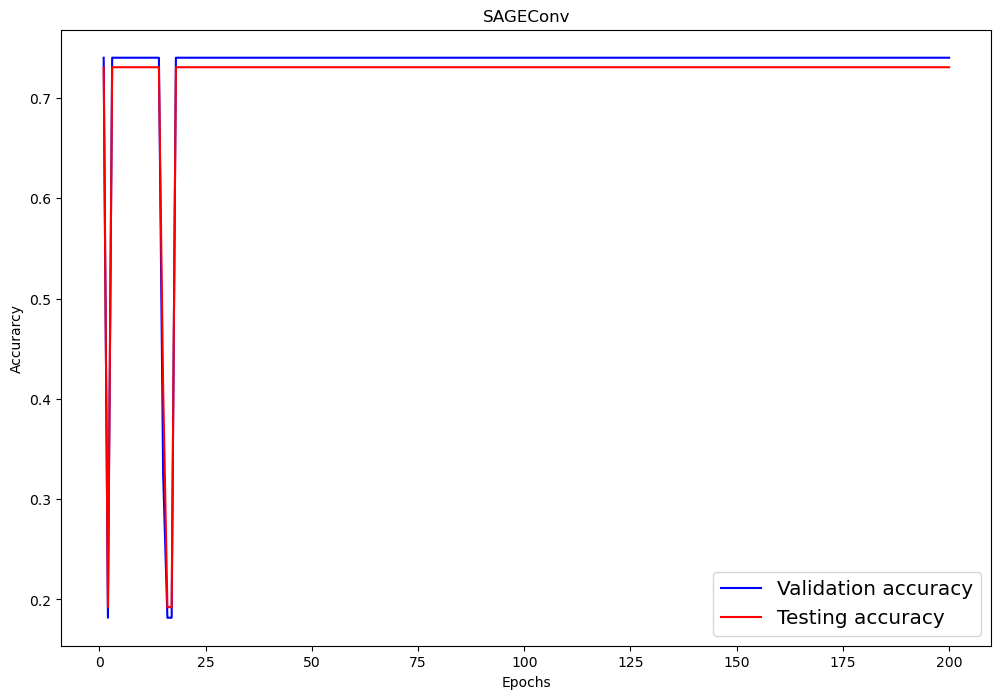

In [17]:
import numpy as np

plt.figure(figsize=(12,8))
plt.plot(np.arange(1, len(val_acc_all) + 1), val_acc_all, label='Validation accuracy', c='blue')
plt.plot(np.arange(1, len(test_acc_all) + 1), test_acc_all, label='Testing accuracy', c='red')
plt.xlabel('Epochs')
plt.ylabel('Accurarcy')
plt.title('SAGEConv')
plt.legend(loc='lower right', fontsize='x-large')
plt.savefig('gat_loss.png')
plt.show()

In [20]:
from sklearn.metrics import confusion_matrix, f1_score
# Calculate confusion matrix and F1 score
mask_val = data.val_mask
mask_test = data.test_mask
model.eval()

out_val = model(data.x, data.edge_index)[mask_val].argmax(dim=1)
out_test = model(data.x, data.edge_index)[mask_test].argmax(dim=1)
y_true_val = data.y[mask_val]
y_true_test = data.y[mask_test]

confusion_matrix_val = confusion_matrix(y_true_val, out_val)
confusion_matrix_test = confusion_matrix(y_true_test, out_test)
f1_score_val = f1_score(y_true_val, out_val, average='weighted')
f1_score_test = f1_score(y_true_test, out_test, average='weighted')

print(f'Validation set\nF1 : {f1_score_val} \nconfusion matrix: \n{confusion_matrix_val}\n')
print(f'Test set\nF1 : {f1_score_test} \nconfusion matrix: \n{confusion_matrix_test}\n')




Validation set
F1 : 0.5112997238981491 
confusion matrix: 
[[50  0  0]
 [ 6  0  0]
 [21  0  0]]

Test set
F1 : 0.617094017094017 
confusion matrix: 
[[57  0  0]
 [ 8  0  0]
 [13  0  0]]

